In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import os

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

%matplotlib inline
%load_ext google.cloud.bigquery

In [2]:
from google.cloud import bigquery
import glob

credential_path = glob.glob(r'../../BQ_Keypath/*.json')
client = bigquery.Client.from_service_account_json(credential_path[0])

# define helper functions
def getQueryAsDF(query):
    return client.query(query).result().to_dataframe()

def getTableSchema(table):
    return client.get_table(table).schema

## 1. Let find the average DAU/MAU ratio for product "stickiness". 
- Product "stickiness" is defined by how often users engage with a product - [geckoboard](https://www.geckoboard.com/best-practice/kpi-examples/dau-mau-ratio/). 
- MAU = total unique active users(create a comment, question or an answer to a question) in a given month. 
- DAU = total unique active users(create a comment, question or an answer to a question)in a given day.
- Ratio = DAU/MAU.
- Tables: _comments_, _posts_questions_, and _post_answers_ 

In [3]:
# looking into comments, question and answer tables schema
schema = getTableSchema('bigquery-public-data.stackoverflow.posts_questions')
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('title', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('body', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('accepted_answer_id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('answer_count', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('comment_count', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('community_owned_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('favorite_count', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('last_activity_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('last_edit_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('last_editor_display_name', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('last_editor_user_id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('owner_display_name', 'STRING', 'NULLABLE', None, (), None),
 Sch

In [4]:
schema = getTableSchema('bigquery-public-data.stackoverflow.posts_answers')
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('title', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('body', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('accepted_answer_id', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('answer_count', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('comment_count', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('community_owned_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('favorite_count', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('last_activity_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('last_edit_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('last_editor_display_name', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('last_editor_user_id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('owner_display_name', 'STRING', 'NULLABLE', None, (), None),
 Schema

In [5]:
schema = getTableSchema('bigquery-public-data.stackoverflow.comments')
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('text', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('post_id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('user_id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('user_display_name', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('score', 'INTEGER', 'NULLABLE', None, (), None)]

In [6]:
schema = getTableSchema('bigquery-public-data.stackoverflow.users')
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('display_name', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('about_me', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('age', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('last_access_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('location', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('reputation', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('up_votes', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('down_votes', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('views', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('profile_image_url', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('website_url', 'STRING', 'NULLABLE', None, (), None)]

In [13]:
from google.cloud.exceptions import NotFound

# combining tables into a view for quick access later.
view_id = "portfolio-331917.stored_views.active_users"

try:
    client.get_table(view_id)
    print('view already exist, skipping')
except NotFound:
    view = bigquery.Table(view_id)
    view.view_query = f"""
                        SELECT
                            creation_date AS active_date,
                            EXTRACT (YEAR FROM creation_date) AS year,
                            EXTRACT (MONTH FROM creation_date) AS month,
                            owner_user_id
                        FROM `bigquery-public-data.stackoverflow.posts_questions`
                        WHERE
                            NOT creation_date IS NULL 
                        UNION ALL 
                        SELECT
                            creation_date AS active_date,
                            EXTRACT (YEAR FROM creation_date) AS year,
                            EXTRACT (MONTH FROM creation_date) AS month,
                            owner_user_id
                        FROM `bigquery-public-data.stackoverflow.posts_answers`
                        WHERE
                            NOT creation_date IS NULL 
                        UNION ALL 
                        SELECT
                            creation_date AS active_date,
                            EXTRACT (YEAR FROM creation_date) AS year,
                            EXTRACT (MONTH FROM creation_date) AS month,
                            user_id AS owner_user_id
                        FROM `bigquery-public-data.stackoverflow.comments`
                        WHERE
                            NOT creation_date IS NULL
                        """
    view = client.create_table(view)

view already exist, skipping


In [10]:
# quick null checking to ensure the table is null free
query = """
        SELECT 
            *
        FROM `portfolio-331917.stored_views.active_users`
        WHERE 
            active_date IS NULL 
            OR year IS NULL 
            OR month IS NULL 
            OR owner_user_id IS NULL 
        """

result = getQueryAsDF(query)
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1961555 entries, 0 to 1961554
Data columns (total 4 columns):
 #   Column         Dtype              
---  ------         -----              
 0   active_date    datetime64[ns, UTC]
 1   year           int64              
 2   month          int64              
 3   owner_user_id  float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(2)
memory usage: 59.9 MB


great, none of the fields have any null value and they are assigned to appropriate data typed. 

In [51]:
# grabbing mau and dau from the saved view
# cte for readability of the sql
query = """
        WITH dau AS
        (
            SELECT 
                DISTINCT DATE(active_date) AS date,
                year, month,
                COUNT(DISTINCT owner_user_id) AS dau
            FROM `portfolio-331917.stored_views.active_users`
            GROUP BY 1,2,3
            ORDER BY 1
        ),

        mau AS
        (
            SELECT 
                year, month,
                COUNT(DISTINCT owner_user_id) AS mau
            FROM `portfolio-331917.stored_views.active_users`
            GROUP BY 1,2
            ORDER BY 1,2
        )

        SELECT 
            date,
            dau.year,
            dau.month,
            FORMAT_DATE("%a", date) AS weekday,
            dau.dau,
            (dau.dau/mau.mau * 100) AS ratio
        FROM 
            dau JOIN 
            mau ON dau.year = mau.year AND dau.month = mau.month
        WHERE 
            DATE_DIFF(DATE "2021-08-31", DATE(date), DAY) <= 120
            AND EXTRACT(MONTH FROM date) != 9
        ORDER BY date DESC
        """

df_dau_mau = getQueryAsDF(query)
df_dau_mau

,date,year,month,weekday,dau,ratio
0,2021-08-31,2021,8,Tue,15258,8.008020
1,2021-08-30,2021,8,Mon,13942,7.317329
2,2021-08-29,2021,8,Sun,8752,4.593406
3,2021-08-28,2021,8,Sat,8451,4.435429
4,2021-08-27,2021,8,Fri,13988,7.341472
...,...,...,...,...,...,...
116,2021-05-07,2021,5,Fri,14215,7.248742
117,2021-05-06,2021,5,Thu,15656,7.983560
118,2021-05-05,2021,5,Wed,15224,7.763267
119,2021-05-04,2021,5,Tue,14772,7.532776


In [52]:
df_dau_mau.describe()

,year,month,dau,ratio
count,121.0,121.000000,121.000000,121.000000
mean,2021.0,6.528926,12627.363636,6.618908
std,0.0,1.118588,2880.020249,1.498425
min,2021.0,5.000000,7488.000000,4.054076
25%,2021.0,6.000000,8843.000000,4.557299
50%,2021.0,7.000000,13836.000000,7.231610
75%,2021.0,8.000000,14737.000000,7.763228
max,2021.0,8.000000,15913.000000,8.218479


We can estimate the population mean of the dau/mau ratio is ~8.74% with standard deviation of 3.42%. That is quite low for the platform "stickiness" comparing to industry standard of 20%.

let find the 95% CI for the true population mean of the dau/mau ratio.

Text(0.5, 1.0, 'DAU/MAU ratio')

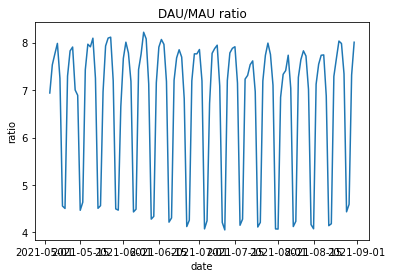

In [53]:
sns.lineplot(data = df_dau_mau, x = 'date', y = 'ratio')
plt.title('DAU/MAU ratio')

In [38]:
import scipy.stats as st

ratio = df_dau_mau["ratio"].values
confi_lvl = .95
ratio_mean = np.mean(ratio)
std_err_mean = st.sem(ratio) 

# note: using the st.norm instead of st.t due to the dataset size. With CLT, we can assume the dataset is normally distr. 
ratio_ci = st.norm.interval(alpha = confi_lvl, loc = ratio_mean, scale = std_err_mean)
ratio_ci

(5.993372378786439, 7.0723847445717825)

Text(0.5, 1.0, 'DAU/MAU ratio')

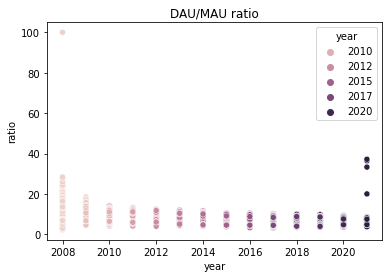

In [19]:
# plotting the data points 
sns.scatterplot(data = df_dau_mau, x = 'year', y = 'ratio', hue = 'year')
plt.title('DAU/MAU ratio')

There is 1 data point with 100% dau/mau ratio. This fell on the date of 2008-07-31, 1 and a half month before the platform publicly launch. There were 3 users for both dau and mau for that date. 

I decided to included this data point since it was interesting to see the dataset goes back prelaunch date(2008-09-15). More importantly, it does not impact the estimated population mean or the CI enough to make a difference. 

For more insight, we can dive into cohort analysis to understand the retention rate in another project. 

Notice, there is a slight negative trend in dau/mau ratio.

## 2. Total inactive users and the total users population
- query to find the total inactive users and the entire population.

In [9]:
# the query is a bit noisy but does the job just fine.
query = """
        -- CTE for all active sessions in the last 90 days
        WITH all_actives AS
        (
            SELECT
                id AS owner_user_id
            FROM `bigquery-public-data.stackoverflow.users`
            WHERE
                NOT creation_date IS NULL
                AND DATE_DIFF(DATE "2021-09-05", DATE(last_access_date), DAY) <= 90
            UNION ALL 
            SELECT
                id AS owner_user_id
            FROM `bigquery-public-data.stackoverflow.comments`
            WHERE
                NOT creation_date IS NULL
                AND DATE_DIFF(DATE "2021-09-05", DATE(creation_date), DAY) <= 90
            UNION ALL 
            SELECT
                id AS owner_user_id
            FROM `bigquery-public-data.stackoverflow.posts_questions`
            WHERE
                NOT creation_date IS NULL
                AND DATE_DIFF(DATE "2021-09-05", DATE(creation_date), DAY) <= 90
            UNION ALL 
            SELECT
                id AS owner_user_id
            FROM `bigquery-public-data.stackoverflow.posts_answers`
            WHERE
                NOT creation_date IS NULL
                AND DATE_DIFF(DATE "2021-09-05", DATE(creation_date), DAY) <= 90
        )

        SELECT 
            (SELECT COUNT(DISTINCT owner_user_id) FROM all_actives) AS active,
            (SELECT COUNT(DISTINCT id) FROM `bigquery-public-data.stackoverflow.users`) - (SELECT COUNT(DISTINCT owner_user_id) FROM all_actives) AS inactive
        """

result = getQueryAsDF(query)
result

,active,inactive
0,5456778,10082167
